# imports and keys

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
env_path = find_dotenv()
load_dotenv(env_path)
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
GOOGLE_CX = os.getenv('GOOGLE_CX')

#from google_images_search import GoogleImagesSearch
#from google.cloud import vision

# FUNCTION text_detection_full_response

In [99]:
def text_detection_full_response(path):
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    return response

# FUNCTION strip_menu

In [100]:
def strip_menu(response):
    
    # remove these chars from entry
    chars_to_remove = '0123456789!"\'#$%&()*+,-./:;<=>?@[\]^_`{|}~♦●★‒…£¡™¢∞§¶•ªº–≠≠œ∑´®†¥¨≤≥÷ç√€'

    # remove entry if it exactly matches any of these
    drop_exact_words = ['sandwiches','restaurant','menu',
                        'restaurant menu','thank you','drinks',
                        'appetizer','appetizers','mains','dessert',
                        'side','sides','side order','breakfast','lunch'
                       'dinner','supper','starter','starters','local',
                        'fresh','food','main']
    
    # remove these words from entry
    words_to_remove = ['menu','restaurant','price','appetizer',
                       'appetizers','course','price','extra','extras']

    # remove entry if it contains any of these
    drop_contain_words = ['tax','consumer','advisory','illness']
    
    # remove entry if it starts with any of these
    drop_start_words = ['include','includes','including','lorem','with','and',
                       'served','serve']
    
    # drop entry if it contains fewer chars than minimum
    min_length = 4
    
    
    text = response.text_annotations[0].description
    menu_original = text.split('\n')
    
    menu_chars_removed = []
    for item in menu_original:
        for char in chars_to_remove:
            item = item.replace(char,'')
        menu_chars_removed.append(item)
        
    menu_exact_matches_dropped = []
    for item in menu_chars_removed:
        if item.lower() in drop_exact_words:
            pass
        else:
            menu_exact_matches_dropped.append(item)
        
    menu_words_removed = []
    for item in menu_exact_matches_dropped:
        temporary = []
        for word in item.split(' '):
            if word.lower() not in words_to_remove:
                temporary.append(word)
        remaining_words = ' '.join(temporary)
        menu_words_removed.append(remaining_words)
         
    menu_contains_dropped = []
    for item in menu_words_removed:
        temporary = []
        for word in item.split(' '):
            if word.lower() in drop_contain_words:
                temporary = []
                pass
            else:
                temporary.append(word)
        remaining_words = ' '.join(temporary)
        menu_contains_dropped.append(remaining_words)
        
    menu_starts_dropped = []
    for item in menu_contains_dropped:
        temporary = item.split(' ')
        if temporary[0].lower() in drop_start_words:
            pass
        else:
            menu_starts_dropped.append(item)
    
    menu_exact_matches_dropped = []
    for item in menu_starts_dropped:
        if item.lower() in drop_exact_words:
            pass
        else:
            menu_exact_matches_dropped.append(item)
            
    bounding_white_space_removed = [item.strip() for item in menu_exact_matches_dropped]
    too_short_dropped = [item for item in bounding_white_space_removed if len(item) >= min_length]
    stripped_menu = too_short_dropped
   
    print(menu_original)
    return(stripped_menu)

# FUNCTION optimized_image_fetch_and_check

In [97]:
def optimized_image_fetch_and_check(query):
    from google_images_search import GoogleImagesSearch
    from google.cloud import vision
    
    print(f'searching for {query}...')
    print()

    gis = GoogleImagesSearch(GOOGLE_API_KEY,GOOGLE_CX)
    
    _search_params = {
    'q': f'{query} recipe',
    'num': 1,
    'imgSize': 'large',
    'imgType': 'photo',
    'imgColorType': 'color'}
    
    gis.search(search_params=_search_params)
    print('fetching image:')
    if len(gis.results()) == 0:
        print('no image found, not verified as food.')
        print()
        return None
    
    url = gis.results()[0].url
    print(url)
    print()
    
    verified_queries = ['cheeseburger','burger','pizza','fried chicken','ice cream sundae']
    
    if query.lower() in verified_queries:
        print(f'{query} already in known foods database, no need to verify!')
        print()
        return url
    
    client = vision.ImageAnnotatorClient()
    image = vision.Image()
    image.source.image_uri = url
    
    response = client.label_detection(image=image, max_results=1)
    label = [lab.description for lab in response.label_annotations]
    score = [lab.score for lab in response.label_annotations]
    
    print('verification filter:')
    print('label must be Food')
    print('score must be above .96')
    print()
    print(f'label: {label}')
    print(f'label score: {score}')
    print()
    
    try:
        if label[0] == 'Food' and score[0] > .96:
            print('verified as food!')
            print()
            print(url)
            print()
            return url
    except IndexError:
        print('label missing, not verified as food')
        return None
        
    
    if label[0] in ['Food', 'Tableware']:
        text_response = client.text_detection(image=image)
        texts = text_response.text_annotations
        n_chars = 0
        if len(texts)>0:
            n_chars = len(texts[0].description)
    
    
        print('verification filter:')
        print('label must be Food or Tableware')
        print('score must be above .96')
        print('number of chars must be below 100')
        print()
    
        print(f'label: {label}')
        print(f'label score: {score}')
        print(f'chars detected: {n_chars}')
        print()
    
        if (label[0] == 'Food' or label[0] == 'Tableware') and score[0] > .96 and n_chars < 100:
            print('verified as food!')
            print()
            print(url)
            print()
            return url
    
    _search_params = {
    'q': f'{query} recipe',
    'num': 3,
    'imgSize': 'large',
    'imgType': 'photo',
    'imgColorType': 'color',
    'safe': 'medium'}
        
    gis = GoogleImagesSearch(GOOGLE_API_KEY,GOOGLE_CX)
    gis.search(search_params=_search_params)
    urls = [result.url for result in gis.results()]
    print('fetching additional images:')
    if len(urls)<=1:
        print('no additional images found, not verified as food')
        return None
    urls = urls[1:]
    for url in urls:
        print(url)
    print()
    
    print('verification filter:')
    print('label must be Food')
    print('score must be above .96')
    print()
    
    labels = []
    scores = []
    for url in urls:
        image.source.image_uri = url
        response = client.label_detection(image=image, max_results=1)
        label = [lab.description for lab in response.label_annotations]
        score = [lab.score for lab in response.label_annotations]
        labels.append(label)
        scores.append(score)
        
    print(f'labels: {labels}')
    print(f'label scores: {scores}')
    print()

    try:
        for label,score in zip(labels,scores):
            if label[0] == 'Food' and score[0] > .96:
                print('verified as food!')
                print()
                print(urls[labels.index(label)])
                print()
                return urls[labels.index(label)]
    except IndexError:
        print('label missing, not verified as food')
        return None
        
        
    if label[0] in ['Food', 'Tableware']:
        char_counts = []   
        for url in urls:
            text_response = client.text_detection(image=image)
            texts = text_response.text_annotations
            n_chars = 0
            if len(texts)>0:
                n_chars = len(texts[0].description)
            char_counts.append(n_chars)
        
        print('verification filter:')
        print('label must be Food or Tableware')
        print('score must be above .96')
        print('number of chars must be below 100')
        print()  
    
        print(f'labels: {labels}')
        print(f'label score: {scores}')
        print(f'chars detected: {char_counts}')
        print()
    
        for label,score,chars in zip(labels,scores,char_counts):
            if (label[0] == 'Food' or label[0] == 'Tableware') and score[0] > .96 and chars < 100:
                print('verified as food!')
                print()
                print(urls[labels.index(label)])
                print()
                return urls[labels.index(label)]
        
    print('not verified as food.')
    print()
    return None

In [96]:
optimized_image_fetch_and_check('ikea')

searching for ikea...

fetching image:
https://static.demilked.com/wp-content/uploads/2017/06/ikea-cooking-recipes-1.jpg

verification filter:
label must be Food
score must be above .96

label: ['Tableware']
label score: [0.9067867994308472]

verification filter:
label must be Food or Tableware
score must be above .96
number of chars must be below 100

label: ['Tableware']
label score: [0.9067867994308472]
chars detected: 40

fetching additional images:
https://mymodernmet.com/wp/wp-content/uploads/2017/06/ikea-cooking-instructions-18.jpg
https://static.designboom.com/wp-content/uploads/2017/06/ikea-cook-this-page-designboom-01.gif

verification filter:
label must be Food
score must be above .96

labels: [[], ['Tableware']]
label scores: [[], [0.9486872553825378]]

label missing, not verified as food


# detect_text_boxes

In [208]:
def detect_text_boxes(response):
    
    import pandas as pd
    
    texts = response.text_annotations

    text_list = []
    bounding_all = []
    top_left = []
    top_right = []
    bottom_left = []
    bottom_right = []


    for text in texts[1:]:
        print('\n"{}"'.format(text.description))
        new_text = '''{}'''.format(text.description)
        text_list.append(new_text)
        

        vertices = [tuple((vertex.x, vertex.y)) for vertex in text.bounding_poly.vertices]

        print('bounds: {}'.format(','.join(vertices)))
        new_bounding = vertices
        bounding_all.append(new_bounding)
        top_left.append(vertices[0])
        top_right.append(vertices[1])
        bottom_left.append(vertices[3])
        bottom_right.append(vertices[2])
        left_up_x.append(vertices[0][0])


        
    menu_df = pd.DataFrame({
        'text': text_list,
        'bounding_all': bounding_all,
        'top_left': top_left,
        'top_right': top_right,
        'bottom_left': bottom_left,
        'bottom_right': bottom_right
    })

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
    return menu_df

#  text_show_cords

In [624]:
def text_show_cords(path):
    import io
    from google.cloud import vision
    from matplotlib import pyplot as plt
    from matplotlib import patches as pch
  
    client = vision.ImageAnnotatorClient()
    
    with io.open(path, 'rb') as image:
        content = image.read()
      
    image = vision.Image(content = content)
    response = client.text_detection(image = image)
    texts = response.text_annotations
    
    a = plt.imread(path)
    fig, ax = plt.subplots(1)
    ax.imshow(a)
    
    for text in texts:
        #print(text.description)
      
        vertices = ([(vertex.x, vertex.y) 
                 for vertex in text.bounding_poly.vertices]) 
    
        #print('Vertices covering text: {}\n\n'.format(vertices))
        rect = pch.Rectangle(vertices[0], (vertices[1][0] - vertices[0][0]), 
                        (vertices[2][1] - vertices[0][1]), linewidth = 1, 
                                       edgecolor ='r', facecolor ='none') 
        ax.add_patch(rect)
    

# paths to menus

In [ ]:
path_start = '../raw_data/all_menus/'

paths = ['warung_sika_food.jpg',
'chinese_menu_1.png',
'english_menu_1.png',
'english_menu_2.jpg',
'english_menu_3.jpg',
'english_menu_4.jpg',
'english_menu_5.jpg',
'english_menu_6.jpg',
'english_menu_7.png',
'english_menu_8.png',
'english_menu_9.jpg',
'english_menu_10.jpg',
'english_menu_11.jpg',
'english_menu_12.png',
'indo_menu_1.png',
'saudi_menu_1.jpeg',
'spanish_menu_1.jpg',
'spanish_menu_2.jpg',
'thai_menu_1.png',
'warung_sika_drinks.jpg']

# text detected menus 

In [ ]:
detected_menus = []
for path in paths:
    detected_menus.append(text_detection_full_response(path_start + path))

#  show menu

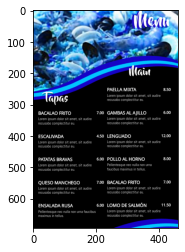

In [608]:
import cv2
import matplotlib.pyplot as plt


img = cv2.imread(path_start + paths[16])
plt.imshow(img)


# sandbox

In [609]:
test_menu = detected_menus[16]

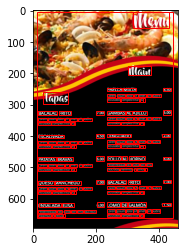

In [622]:
text_show_cords(path_start + paths[16])

In [611]:
sample_df = detect_text_boxes(test_menu)
sample_df['height'] = abs(sample_df['top_left'].str[1] - sample_df['bottom_left'].str[1])

In [612]:
sample_df['line_cord'] = sample_df['bottom_left'].str[1]

In [613]:
sample_df = sample_df.sort_values(by='line_cord')

In [614]:
sample_df

,text,bounding_all,top_left,top_right,bottom_left,bottom_right,height,line_cord
73,Menu,"[(319, 6), (434, 7), (433, 56), (318, 55)]","(319, 6)","(434, 7)","(318, 55)","(433, 56)",49,55
74,Main,"[(302, 178), (375, 177), (375, 207), (303, 208)]","(302, 178)","(375, 177)","(303, 208)","(375, 207)",30,208
159,8.50,"[(415, 248), (438, 248), (438, 256), (415, 256)]","(415, 248)","(438, 248)","(415, 256)","(438, 256)",8,256
76,MIXTA,"[(287, 246), (327, 246), (327, 256), (287, 256)]","(287, 246)","(327, 246)","(287, 256)","(327, 256)",10,256
75,PAELLA,"[(236, 246), (283, 246), (283, 257), (236, 257)]","(236, 246)","(283, 246)","(236, 257)","(283, 257)",11,257
...,...,...,...,...,...,...,...,...
158,.,"[(349, 648), (353, 648), (353, 658), (349, 658)]","(349, 648)","(353, 648)","(349, 658)","(353, 658)",10,658
67,.,"[(95, 649), (100, 649), (100, 659), (95, 659)]","(95, 649)","(100, 649)","(95, 659)","(100, 659)",10,659
66,tellus,"[(70, 649), (95, 649), (95, 659), (70, 659)]","(70, 649)","(95, 649)","(70, 659)","(95, 659)",10,659
65,in,"[(60, 649), (67, 649), (67, 659), (60, 659)]","(60, 649)","(67, 649)","(60, 659)","(67, 659)",10,659


In [615]:
import pandas as pd

all_lines = []
avg_heights = []
line_cords = []
for n in sample_df['line_cord'].unique():
    same_line_df = sample_df[sample_df['line_cord']==n] 
    same_line = []
    heights = []
    for text,height in zip(same_line_df['text'],same_line_df['height']):
        same_line.append(text)
        heights.append(height)
    all_lines.append(' '.join(same_line))
    avg_height = int(sum(heights)/len(heights))
    avg_heights.append(avg_height)
    line_cords.append(n)


In [616]:
strict_combine_df = pd.DataFrame({'text': all_lines, 'avg_height': avg_heights, 'line_cords': line_cords})
strict_combine_df.sort_values(by='avg_height')

,text,avg_height,line_cords
25,8.00,8,476
16,12.00,8,403
2,8.50 MIXTA,9,256
40,11.50,9,623
38,. eu complectitur recusabo,9,584
48,. tellus in maximus,10,659
47,recusabo complectitur eu .,10,658
20,", sit ipsum dolor sit amet audire",10,423
29,Pellentesque nec nulla non urna,10,497
30,"Lorem ipsum dolor sit amet sit audire ,",10,498


In [617]:
temp_df = strict_combine_df
temp_df['soft_line_cords'] = temp_df['line_cords']//7

all_lines = []
soft_avg_heights = []
line_cords = []
for n in temp_df['soft_line_cords'].unique():
    same_line_df = temp_df[temp_df['soft_line_cords']==n] 
    same_line = []
    heights = []
    for text,height in zip(same_line_df['text'],same_line_df['avg_height']):
        same_line.append(text)
        heights.append(height)
    soft_avg_height = int((sum(heights)/len(heights))//2)
    all_lines.append(' '.join(same_line))
    soft_avg_heights.append(soft_avg_height)
    line_cords.append(n)

In [618]:
soft_combine_df = pd.DataFrame({'text': all_lines, 'soft_avg_height': soft_avg_heights, 'soft_line_cords': line_cords})
soft_combine_df.sort_values(by='soft_avg_height')


,text,soft_avg_height,soft_line_cords
19,. eu complectitur recusabo recusabo complectit...,4,83
11,", sit ipsum dolor sit amet audire Lorem Lorem ...",5,60
18,"Lorem , ipsum audire sit sit amet dolor Lorem ...",5,81
16,7.00,5,78
15,. faucibus maximus in tellus complectitur . eu...,5,73
14,Pellentesque nec nulla non urna Lorem ipsum do...,5,71
13,8.00 AL POLLO HORNO 6.00 PATATAS BRAVAS,5,68
12,complectitur . eu complectitur recusabo recusa...,5,62
21,"audire sit , amet dolor sit ipsum Lorem faucib...",5,92
10,ESCALIVADA,5,58


In [568]:
test_menu_2

text_annotations {
  locale: "en"
  description: "Salads\nICEBERG WEDGE\navocado, chopped egg, grape tomato, creamy bleu cheese,\nbacon vinaigrette....\n15\nORGANIC BABY KALE\nroasted coriander spring carrots, fennel, toasted focaccia, ricotta\nsalata, lemon vinaigrette........\n.17\nTHE GREEK\nbaby red romaine, feta, cucumber, olives, tomato, red onion,\nfeta-phyllo triangle, oregano vinaigrette..........\n19\nCHINESE CHICKEN SALAD\nchopped warm chicken, napa cabbage, shredded carrot, wonton crisp,\ngreen beans, Mandarin oranges, roast Virginia peanuts,\nsoy-ginger dressing.......\nwww. .19\nTE CAESAR\nhearts of romaine, grilled travesano, anchovy,\ngarlic parmesan dressing......\n17\nBABY ARUGULA & BLACKBERRIES\nsweet curried pecan, avocado, Bermuda onion,\nhoney-sherry vinaigrette........\n19\nLOBSTER COBB SALAD\ncucumber, avocado, tomato, bacon, blue cheese, egg,\nred wine vinaigrette.....\n28\nFIRE GRILLED OCTOPUS\nfingerling potatoes, dried black olive, sweet pimento, olive oil, 